In [2]:
pip install nba_api

  Using cached https://files.pythonhosted.org/packages/98/bc/f701f6f7c79354419107e2534d22ed27bac7de9a6c2d85ab73f87bc140a9/nba_api-1.1.5-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import json

from nba_api.stats.static import teams

nba_teams = teams.get_teams()
# Select the dictionary for the desired team, which contains their team ID
Lakers = [team for team in nba_teams if team['abbreviation'] == 'LAL'][0]
Lakers_id = Lakers['id']
from nba_api.stats.endpoints import leaguegamefinder

# Query for games where the selected team is playing were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=Lakers_id)
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]
games_season = games[games['SEASON_ID'] == '22018']
games_reg = (pd.to_datetime(games_season.GAME_DATE) > pd.to_datetime('2018-10-01'))
games_season_reg = games_season[games_reg]
lakers_sched = games_season_reg.MATCHUP.str[-3:]
lakers_sched_flip = lakers_sched[::-1]

In [4]:
%%bash

wget -nc -P /home/jovyan/Fall2019/assignments/assignment2/Data https://ucsb.box.com/shared/static/940qiuxyp798gv4nx8iwvazu9qqjs37e.zip
unzip -o /home/jovyan/Fall2019/assignments/assignment2/Data/940qiuxyp798gv4nx8iwvazu9qqjs37e.zip -d /home/jovyan/Fall2019/assignments/assignment2/Data
unlink /home/jovyan/Fall2019/assignments/assignment2/Data/shotchartdetail\?PlayerID\=2594\&PlayerPosition\=\&Season\=2018-19\&ContextMeasure\=FGA\&DateFrom\=\&DateTo\=\&GameID\=\&GameSegment\=\&LastNGames\=0\&LeagueID\=00\&Location\=\&Month\=0\&OpponentTeamID\=0\&Outcome\=\&Period\=0\&Position\=\&RookieYear\=\&SeasonSegment\=\&Se.1         
unlink /home/jovyan/Fall2019/assignments/assignment2/Data/shotchartdetail\?PlayerID\=101181\&PlayerPosition\=\&Season\=2018-19\&ContextMeasure\=FGA\&DateFrom\=\&DateTo\=\&GameID\=\&GameSegment\=\&LastNGames\=0\&LeagueID\=00\&Location\=\&Month\=\0\&OpponentTeamID\=0\&Outcome\=\&Period\=0\&Position\=\&RookieYear\=\&SeasonSegment\=\&.1

Archive:  /home/jovyan/Fall2019/assignments/assignment2/Data/940qiuxyp798gv4nx8iwvazu9qqjs37e.zip
  inflating: /home/jovyan/Fall2019/assignments/assignment2/Data/commonallplayers?LeagueID=00&Season=2018-19&IsOnlyCurrentSeason=0  
  inflating: /home/jovyan/Fall2019/assignments/assignment2/Data/commonTeamYears?LeagueID=00&Season=2018-19  
  inflating: /home/jovyan/Fall2019/assignments/assignment2/Data/shotchartdetail?PlayerID=101106&PlayerPosition=&Season=2018-19&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&Period=0&Position=&RookieYear=&SeasonSegment=&  
  inflating: /home/jovyan/Fall2019/assignments/assignment2/Data/shotchartdetail?PlayerID=101107&PlayerPosition=&Season=2018-19&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&Period=0&Position=&RookieYear=&SeasonSegment=&  
  inflating: /home/jovyan/Fall2019/assignments/assignme

File ‘/home/jovyan/Fall2019/assignments/assignment2/Data/940qiuxyp798gv4nx8iwvazu9qqjs37e.zip’ already there; not retrieving.



In [5]:
#Allshots taken in 18-19 from HW 2
allshotslist = []

files = !ls -1 /home/jovyan/Fall2019/assignments/assignment2/Data/shotchartdetail*

for f in files:
    edit0_f = f.replace('=', '\=')
    edit1_f = edit0_f.replace('&', '\&')
    edit2_f = edit1_f.replace('?', '\?')
    json_str = !cat {edit2_f}
    json_obj = json.loads(json_str[0])
    h = json_obj['resultSets'][0]['headers'] 
    d = json_obj['resultSets'][0]['rowSet'] 
    allshotslist_temp = pd.DataFrame(d, columns=h)
    allshotslist_df = pd.DataFrame(d, columns=h, index = allshotslist_temp.loc[:,'PLAYER_ID'])
    allshotslist.append(allshotslist_df)

allshots = pd.concat(allshotslist)
 

json_str = !cat /home/jovyan/Fall2019/assignments/assignment2/Data/commonTeamYears\?LeagueID\=00\&Season\=2018-19
json_obj = json.loads(json_str[0])
h = json_obj['resultSets'][0]['headers'] 
d = json_obj['resultSets'][0]['rowSet']  
allteams = pd.DataFrame(d, columns=h)

In [6]:
#Function to determine OPP team record
def record(i): 
    Opponnent = [team for team in nba_teams if team['abbreviation'] == lakers_sched_flip.iloc[i-1]][0] ##
    Opponnent_id = Opponnent['id']
    gamefinder_opp = leaguegamefinder.LeagueGameFinder(team_id_nullable=Opponnent_id)
    games_opp = gamefinder_opp.get_data_frames()[0]
    games_season_opp = games_opp[games['SEASON_ID'] == '22018']
    games_season_reg_opp = games_season_opp[pd.to_datetime(games_season_opp.GAME_DATE) > pd.to_datetime('2018-10-01')]
    games_before_reg_opp = games_season_reg_opp[pd.to_datetime(games_season_opp.GAME_DATE) < pd.to_datetime(games_season_reg.iloc[-i, 5])]
    win = sum(games_before_reg_opp.WL == 'W')
    loss = len(games_before_reg_opp) - win
    return(str(games_opp.TEAM_NAME[0]) + ' (' + str(win) + '-' + str(loss) + ')')

In [7]:
#function to determine if ith game is back-to-back for OPP
def Back_to_back(i): 
    Opponnent = [team for team in nba_teams if team['abbreviation'] == lakers_sched_flip.iloc[i-1]][0] ##
    Opponnent_id = Opponnent['id']
    gamefinder_opp = leaguegamefinder.LeagueGameFinder(team_id_nullable=Opponnent_id)
    games_opp = gamefinder_opp.get_data_frames()[0]
    games_season_opp = games_opp[games['SEASON_ID'] == '22018']
    games_season_reg_opp = games_season_opp[pd.to_datetime(games_season_opp.GAME_DATE) > pd.to_datetime('2018-10-01')]
    games_before_reg_opp = games_season_reg_opp[pd.to_datetime(games_season_opp.GAME_DATE) < pd.to_datetime(games_season_reg.iloc[-i, 5])]
    if((pd.to_datetime(games_season_reg.iloc[-i, 5]) - pd.to_datetime(games_before_reg_opp.iloc[0, 5])).days > 1):
        return('Not 2nd night of back-to-back')
    else:
        return('2nd night of back-to-back')

In [8]:
#gives the OPP relevant shots for the ith game analysis 
def relevant(i): 
    return(allshots[(allshots.TEAM_ID == int(allteams.TEAM_ID[allteams.ABBREVIATION == lakers_sched_flip.iloc[i-1]])) & (allshots.GAME_ID < games_season_reg.iloc[-i, 4])])

In [9]:
#finds rebounding averages of opponnent at ith game 
def rebounds(g):
    names = np.unique(FG.index.tolist())


    player_name = []
    for i in names:
        if not i.isdigit():
            player_name.append(i)

    player_ID = []
    for i in player_name:
        ID = np.unique(allshots[allshots['PLAYER_NAME'] == i]['PLAYER_ID'])
        player_ID.append(ID)

    from nba_api.stats.endpoints import playerdashboardbygamesplits
    REB = []

    for i in player_ID: #Game number in here
        REB_DATA = playerdashboardbygamesplits.PlayerDashboardByGameSplits(player_id = i, season = '2018-19', period = 0, date_to_nullable = games_season_reg.iloc[-g, 5]).get_data_frames()
        REB.append(REB_DATA[2][['OREB', 'DREB']])

    REB_data = REB

    for i in range(len(REB_data)):
        REB_data[i]['PLAYER_NAME'] = player_name[i]
        REB_data[i]['PERIOD'] = range(1,len(REB_data[i]) + 1)
        REB_data[i] = REB_data[i].groupby(['PLAYER_NAME', 'PERIOD']).mean()
    
    games = []
    for i in range(len(player_ID)): #game number here 
        average = allshots[(allshots['PLAYER_ID'] == player_ID[i][0]) & (allshots.GAME_ID < games_season_reg.iloc[-g, 4])]
        length = len(average['GAME_DATE'].unique())
        games.append(length)
    
    for i in range(len(REB_data)):
        REB_data[i] = REB_data[i]/games[i]

    return(REB_data)

In [10]:
#Function from assignemnt two to plot shot charts
def bin_shots(df, bin_edges, density=False, sigma=1):
    
    """Given data frame of shots, compute a 2d matrix of binned counts is computed
    
    Args:
        df: data frame of shotchartdetail from nba.com. 
            At the minimum, variables named LOCX and LOCY are required.
        bin_edges: bin edge definition: edges in x and edges in y
    
    Returns:
        binned: counts
        xedges: bin edges in X direction
        yedges: bin edges in Y direction
    """
    import numpy as np
    from scipy import ndimage
    x = list(np.asarray(df.LOC_X))
    y = list(np.asarray(df.LOC_Y))
    hist = np.histogram2d(x, y, bins = bin_edges)
    binned = hist[0]
    xedges = hist[1]
    yedges = hist[2] 
    
    if density:

        # Recompute 'binned' using "gaussian_filter"
        binned = ndimage.filters.gaussian_filter(binned , sigma = sigma)
        
        # Normalize the histogram to be a "density", e.g. mass across all bins sums to 1.
        binned /= np.sum(binned)
    
    return(binned, xedges, yedges)

xedges = np.linspace(start=-300, stop=300, num=151)
yedges = np.linspace(start=-48, stop=372, num=106)
bin_edges = (xedges, yedges)

def plot_shotchart(binned_counts, xedges, yedges, ax=None, use_log=False, cmap = 'Reds'):
    
    """Plots 2d heatmap from vectorized heatmap counts
    
    Args:
        hist_counts: vectorized output of numpy.histogram2d
        xedges, yedges: bin edges in arrays
        ax: figure axes [None]
        use_log: will convert count x to log(x+1) to increase visibility [False]
        cmap: Set the color map https://matplotlib.org/examples/color/colormaps_reference.html
    Returns:
        ax: axes with plot
    """
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    ## number of x and y bins.  
    nx = xedges.size - 1
    ny = yedges.size - 1

    X, Y = np.meshgrid(xedges, yedges)
    
    if use_log:
        counts = np.log(binned_counts + 1)
        
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    ax.pcolormesh(X, Y, binned_counts.T, cmap=cmap) 
    ax.set_aspect('equal')
    
    draw_court(ax)
    
    return(ax)

def draw_court(ax=None, color='black', lw=1, outer_lines=False):
    
    from matplotlib.patches import Circle, Rectangle, Arc
    from matplotlib.pyplot import gca
    
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-219, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((219, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.5, theta2=157.5, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

import matplotlib.pyplot as plt


In [11]:
#Function to create nice table
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [12]:
#all relevant close game shots
def close_game(i):
    Opponnent = [team for team in nba_teams if team['abbreviation'] == lakers_sched_flip.iloc[i-1]][0] ##
    Opponnent_id = Opponnent['id']
    gamefinder_opp = leaguegamefinder.LeagueGameFinder(team_id_nullable=Opponnent_id)
    games_opp = gamefinder_opp.get_data_frames()[0]
    games_season_opp = games_opp[games['SEASON_ID'] == '22018']
    games_season_reg_opp = games_season_opp[pd.to_datetime(games_season_opp.GAME_DATE) > pd.to_datetime('2018-10-01')]
    games_before_reg_opp = games_season_reg_opp[pd.to_datetime(games_season_opp.GAME_DATE) < pd.to_datetime(games_season_reg.iloc[-i, 5])]
    games_before_reg_opp.GAME_ID[abs(games_before_reg_opp.PLUS_MINUS) < 6] #close game
    Close_shots = (allshots[(allshots.TEAM_ID == int(allteams.TEAM_ID[allteams.ABBREVIATION == lakers_sched_flip.iloc[i-1]])) & (allshots.GAME_ID.isin(games_before_reg_opp.GAME_ID[abs(games_before_reg_opp.PLUS_MINUS) < 6]))])
    Close_shots_4 = Close_shots[(Close_shots.PERIOD == 4) & (Close_shots.MINUTES_REMAINING < 6) ] #only last 5min of 4th
    Close_shots_4 = Close_shots_4.append(allshots[(((allshots.PERIOD) > 4) & (allshots.TEAM_ID == int(allteams.TEAM_ID[allteams.ABBREVIATION == lakers_sched_flip.iloc[i-1]])) & ((allshots.GAME_ID < games_season_reg.iloc[-i, 4])))  ] ) #5th+ qtr (OT)
    return(Close_shots_4)

In [13]:
Game_number = 35  ##input game number here and run the rest of report
relevant_shots =  relevant(Game_number) 
relevant_shots.SHOT_MADE_FLAG = pd.to_numeric(relevant_shots.SHOT_MADE_FLAG)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
FG = relevant_shots.groupby(['PLAYER_NAME', 'PERIOD']).mean()
PP = (relevant_shots.groupby(['PLAYER_NAME', 'PERIOD']).size()/relevant_shots.groupby(['PERIOD']).size())
FG['proportion']= PP.values

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
REB_data = rebounds(Game_number)
REB_DF = pd.DataFrame()
for i in range(len(REB_data)):
    REB_DF = REB_DF.append(REB_data[i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
FG['OREB/period'] = REB_DF.OREB
FG['DREB/period'] = REB_DF.DREB
FG = FG.rename(columns={"SHOT_MADE_FLAG": "FG %", "proportion": "% of team-shots taken in qtr"})

FGP = FG.round(4).reset_index() 
FGP.ix[FGP.duplicated('PLAYER_NAME') , 'PLAYER_NAME'] = ''

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


In [16]:
record(Game_number) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


'Sacramento Kings (18-18)'

In [17]:
Back_to_back(Game_number)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


'2nd night of back-to-back'

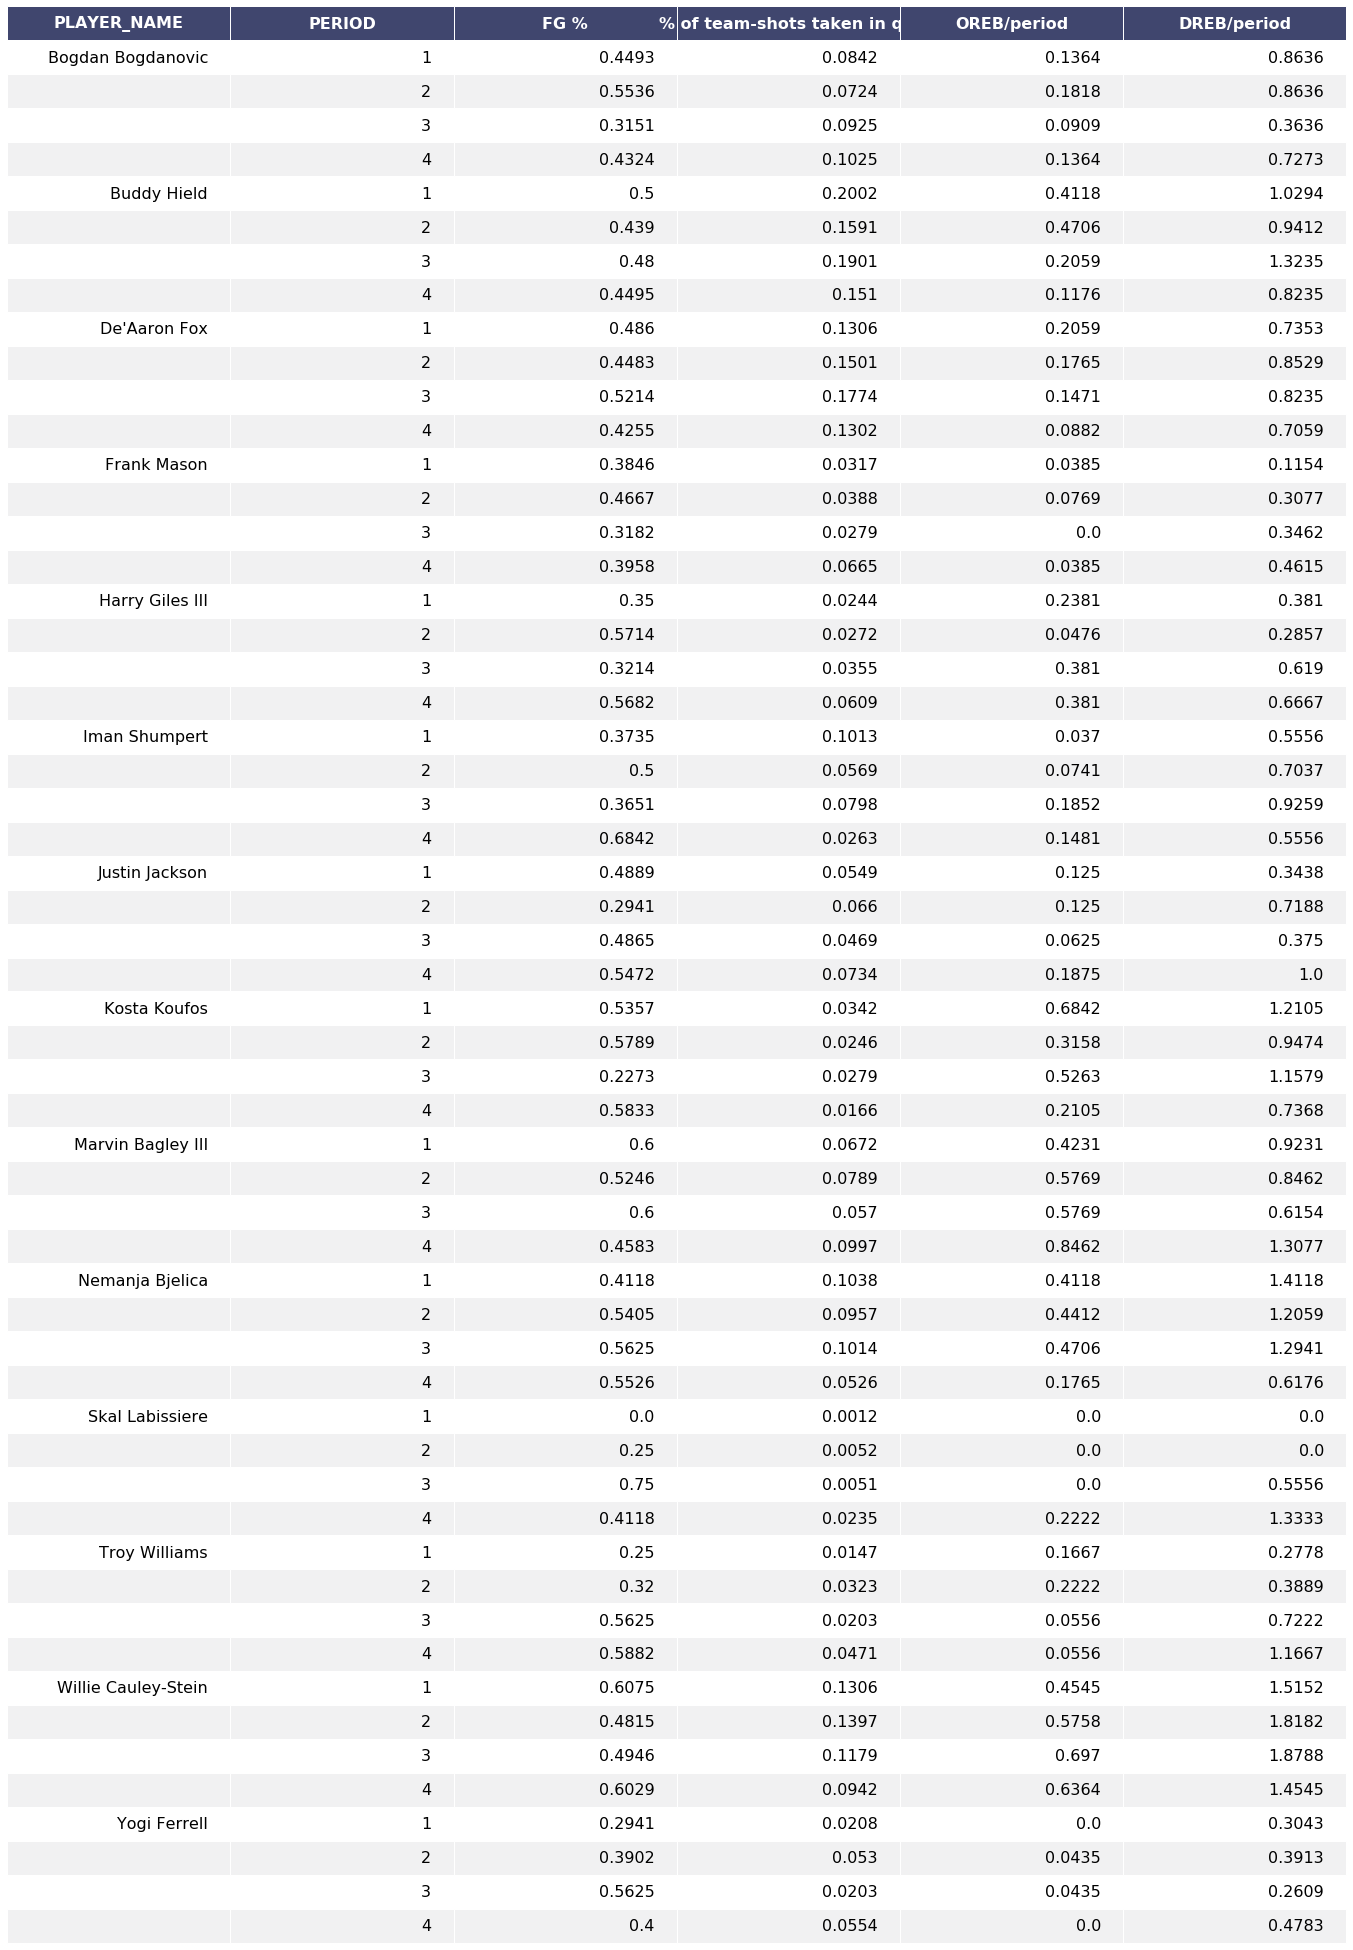

In [18]:
render_mpl_table(FGP, header_columns=0, col_width=4.0, font_size=16)

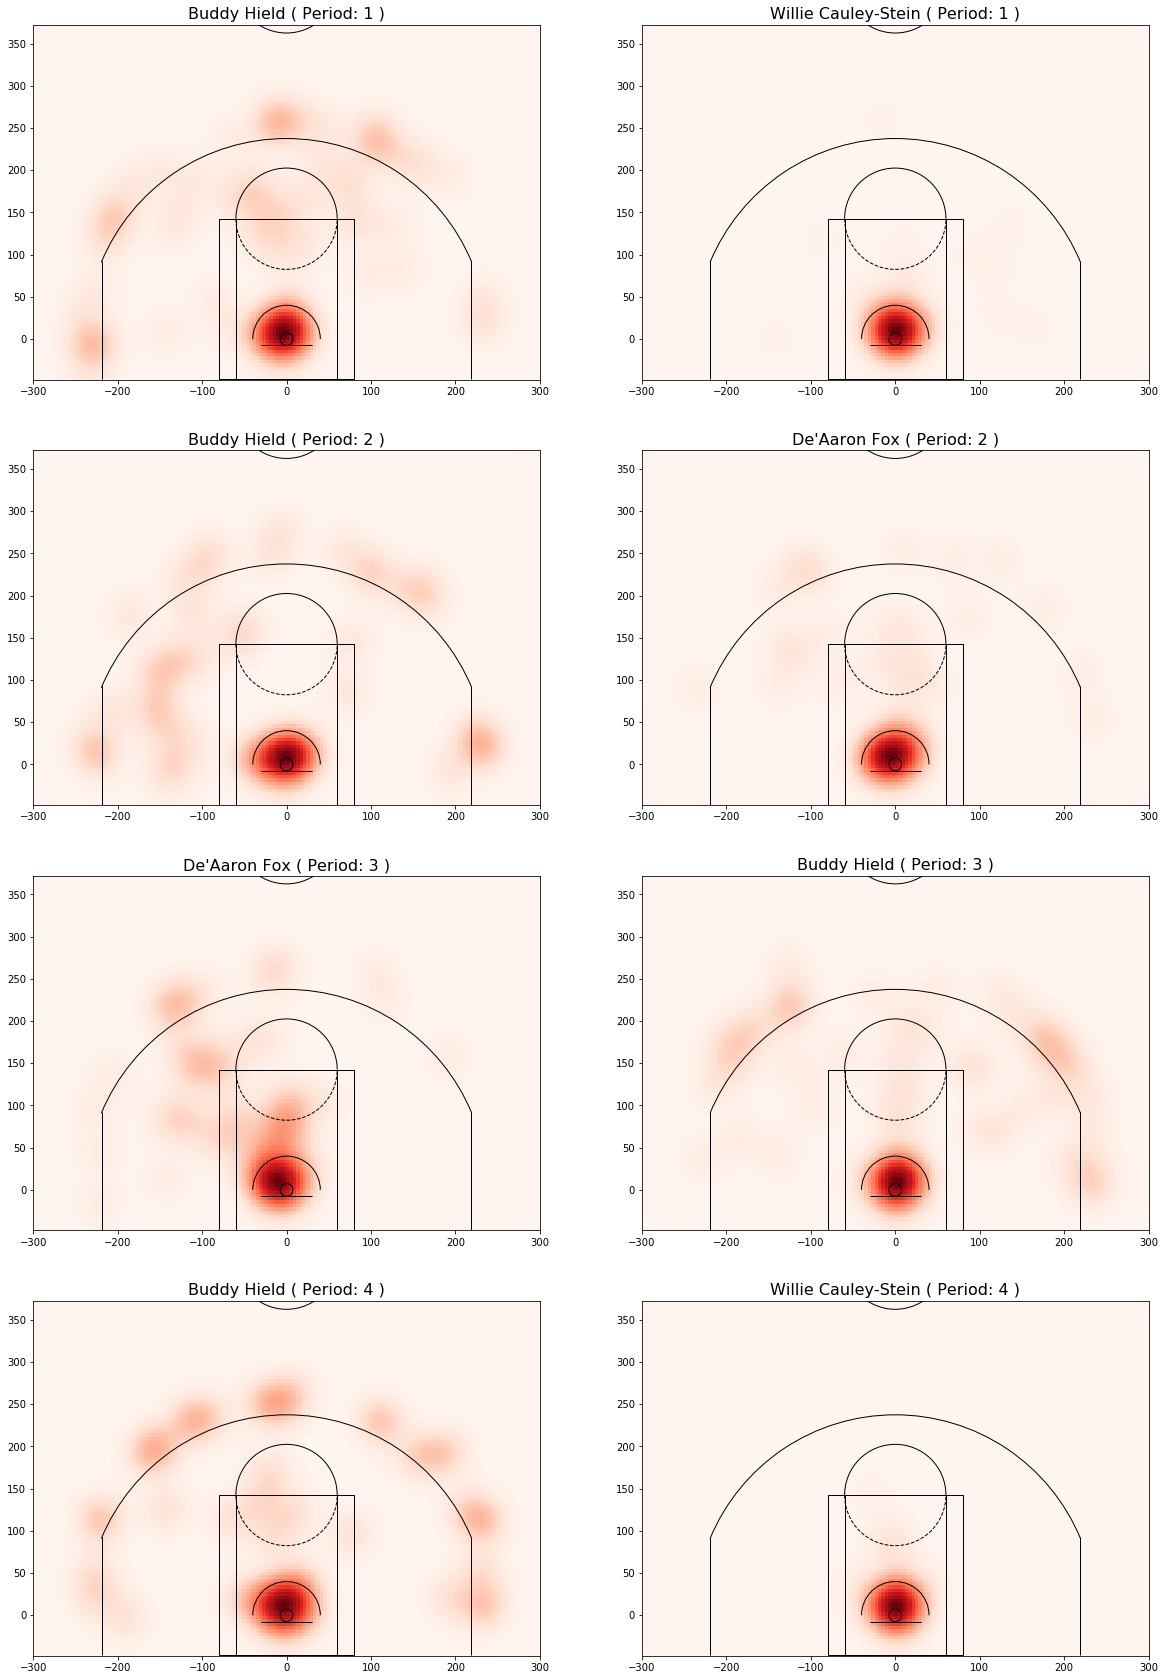

In [19]:
#Plotting top 2 shooters heatmap per qtr
eff = FG
eff["efficiency"] = round(eff["FG %"]*eff["% of team-shots taken in qtr"],4)
sorted_eff = eff.sort_values(["PERIOD","efficiency"], ascending=[True, False])

top2 = sorted_eff.groupby("PERIOD")["efficiency"].nlargest(2)
top2_index = top2.index.get_level_values(level=1)

x = 0
fig, ax = plt.subplots(4,2, figsize = (20,30))

for i in range(1,9):
    if i%2 == 1:
        x = x + 1
    
    subset = relevant_shots[(relevant_shots["PLAYER_NAME"] == top2_index[i-1]) & (relevant_shots["SHOT_MADE_FLAG"] == 1) & (relevant_shots["PERIOD"] == x) ]
    subset0, xe, ye, = bin_shots(subset, bin_edges, density=True, sigma=5) 
    plot_shotchart(subset0, xe, ye, ax=ax[x-1, (i-1)%2])
    ax[x-1, (i%2) - 1].set_title(top2_index[i-1] + " ( " + "Period: %i" %x + " )",  fontsize=16)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


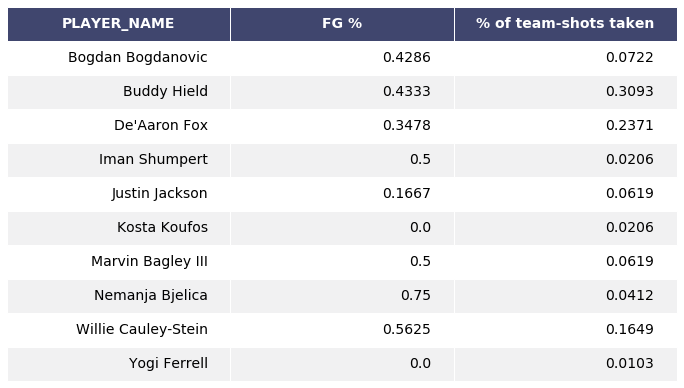

In [20]:
Close_shots_4 = close_game(Game_number)
Close_shots_4.SHOT_MADE_FLAG = pd.to_numeric(Close_shots_4.SHOT_MADE_FLAG)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
Close_game = Close_shots_4.groupby(['PLAYER_NAME']).mean()
PP_close = (Close_shots_4.groupby(['PLAYER_NAME']).size())/len(Close_shots_4)
Close_game['% of team-shots taken']= PP_close.values
Close_game = Close_game.rename(columns={"SHOT_MADE_FLAG": "FG %"})
render_mpl_table(Close_game.round(4).reset_index(), header_columns=0, col_width=4.0)

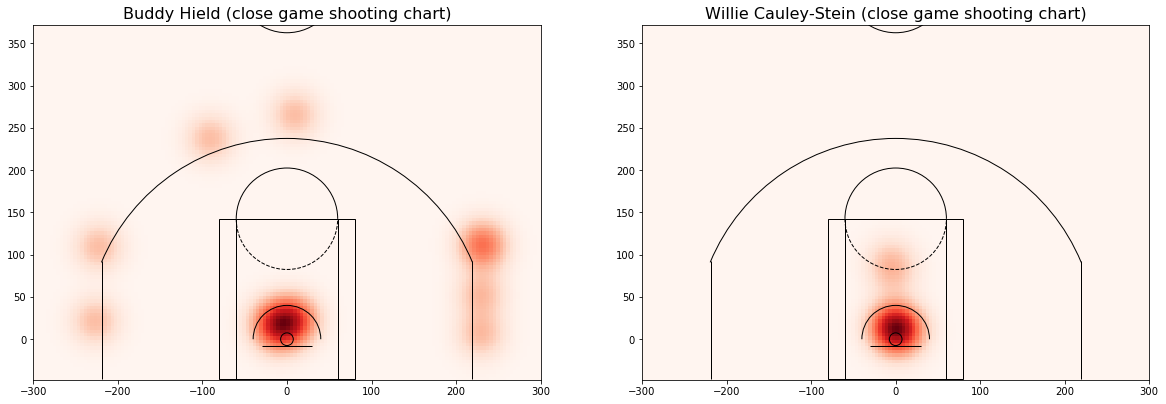

In [21]:
eff2 = Close_game
eff2["efficiency"] = round(eff2["FG %"]*eff2['% of team-shots taken'],4)
sorted_eff2 = eff2.sort_values(["efficiency"], ascending=[True])

top2 = sorted_eff2["efficiency"].nlargest(2)

top2_index = top2.index.get_level_values(level=0)


x = 1

fig, ax = plt.subplots(1,2, figsize = (20,30))

for i in range(1,3):
    
    
    subset = Close_shots_4[(Close_shots_4["PLAYER_NAME"] == top2_index[i-1]) & (Close_shots_4["SHOT_MADE_FLAG"] == 1)]
    subset0, xe, ye, = bin_shots(subset, bin_edges, density=True, sigma=5) #this line fails
    plot_shotchart(subset0, xe, ye, ax=ax[(i-1)])
    ax[(i-1)].set_title(top2_index[i-1] + ' (close game shooting chart)',  fontsize=16)

################ END CHUNK